# Activity 10: Matrix Multiplication Performance Study

**Goal.** This notebook implements and profiles three matrix multiplication strategies (pure Python, Python loops on NumPy arrays, and fully vectorised NumPy) for 500x500 matrices as outlined in the assignment instructions.

## Part 1: Setup
This section imports the required libraries, seeds the random number generator for reproducibility, and prepares the 500x500 test matrices.

In [57]:
import numpy as np
import time
import cProfile
import pstats
import matplotlib.pyplot as plt
import io

np.random.seed(42)

A = np.random.rand(500, 500)
B = np.random.rand(500, 500)

A_list = A.tolist()
B_list = B.tolist()


print(f"A shape: {A.shape}, B shape: {B.shape}")

A shape: (500, 500), B shape: (500, 500)


## Part 2: Matrix Multiplication Implementations
The functions below cover the three required approaches. The first relies purely on Python lists, the second uses NumPy arrays while still iterating explicitly, and the third offloads the work to NumPy's optimised routines.

In [ ]:
def matrix_multiply_python(A, B):
    """
    Matrix multiplication using pure Python nested loops.
    A: m x n matrix stored as a list of lists
    B: n x p matrix stored as a list of lists
    Returns: m x p matrix as a list of lists
    """
    rows_mat1 = len(A) #to get the length of rows for the loop
    cols_mat1 = len(A[0]) #to get the length of cols for the loop 
    rows_mat2 = len(B) #to get the length of rows for the loop
    cols_mat2 = len(B[0]) #to get the length of cols for the loop  
    #need to check A's cols and B's rows are equal
    if cols_mat1 != rows_mat2:
       raise ValueError("Number of columns in A must equal number of rows in B")
        #used aactualy error instead of print message
    res = []
    for i in range(rows_mat1):
        new_row = []
        for j in range(cols_mat2):
            summ = 0
            for k in range(cols_mat1):
                summ += A[i][k] * B[k][j]
            new_row.append(summ)
        res.append(new_row)
        
    return res

def matrix_multiply_numpy_loops(A, B):
    """
    Matrix multiplication using Python loops with NumPy array indexing.
    A: m x n NumPy array (or array-like)
    B: n x p NumPy array (or array-like)
    Returns: m x p NumPy array
    """
    A = np.asanyarray(A)# or asarray?
    B = np.asanyarray(B)# array and asarray difference?
    #NOTE: AI recommendation for faster np.ascontiguousarray also need to use B transpose 
    #NOTE Or use zip for caching rows and cols?
    m, n = A.shape
    n_b, p = B.shape
    if n != n_b:
        raise ValueError("Inner dimensions do not match for multiplication.")
    
    result = np.zeros((m, p), dtype=A.dtype)
    for i in range(m):
        for j in range(p):
            total = 0.0
            for k in range(n):
                total += A[i, k] * B[k, j]
                #NOTE: could use np.dot for the innermost loop? C[i, j] = np.dot(ai, BT[j, :])   # inner product faster
            result[i, j] = total
    return result



def matrix_multiply_numpy(A, B):
    """
    Matrix multiplication using NumPy's vectorized operations.
    A: m x n NumPy array
    B: n x p NumPy array
    Returns: m x p NumPy array
    """
    return A @ B


## Part 3: Profiling and Visualisation
### Basic timing
The next cell times each implementation on the 500x500 matrices, verifies numerical agreement, and stores profiling artefacts for later inspection.

In [59]:
def run_timed(func, *args, capture_profile=False):
    """Time a matrix multiplication function and optionally collect profiling output."""
    profiler = cProfile.Profile() if capture_profile else None
    if profiler is not None:
        profiler.enable()
    start = time.time()
    result = func(*args)
    end = time.time()
    if profiler is not None:
        profiler.disable()
        stream = io.StringIO()
        stats = pstats.Stats(profiler, stream=stream).sort_stats("cumulative")
        stats.print_stats(10)
        profile_output = stream.getvalue()
        profile_meta = {
            "total_calls": stats.total_calls,
            "primitive_calls": stats.prim_calls,
        }
    else:
        profile_output = None
        profile_meta = None
    return end - start, result, profile_output, profile_meta

timings = {}
profiles = {}
profile_metadata = {}

t_python, result_python, profile_python, meta_python = run_timed(matrix_multiply_python, A_list, B_list, capture_profile=True)
timings["Version 1: Pure Python"] = t_python
profiles["Version 1: Pure Python"] = profile_python
profile_metadata["Version 1: Pure Python"] = meta_python

t_numpy_loops, result_numpy_loops, profile_numpy_loops, meta_numpy_loops = run_timed(matrix_multiply_numpy_loops, A, B, capture_profile=True)
timings["Version 2: NumPy loops"] = t_numpy_loops
profiles["Version 2: NumPy loops"] = profile_numpy_loops
profile_metadata["Version 2: NumPy loops"] = meta_numpy_loops

t_numpy, result_numpy, _, _ = run_timed(matrix_multiply_numpy, A, B)
timings["Version 3: Pure NumPy"] = t_numpy
profile_metadata["Version 3: Pure NumPy"] = None

result_python_np = np.array(result_python)
checks = {
    "Version 1 vs Version 2": np.allclose(result_python_np, result_numpy_loops),
    "Version 1 vs Version 3": np.allclose(result_python_np, result_numpy),
    "Version 2 vs Version 3": np.allclose(result_numpy_loops, result_numpy),
}

speedups = {
    "Version 2 vs Version 1": timings["Version 1: Pure Python"] / timings["Version 2: NumPy loops"],
    "Version 3 vs Version 1": timings["Version 1: Pure Python"] / timings["Version 3: Pure NumPy"],
    "Version 3 vs Version 2": timings["Version 2: NumPy loops"] / timings["Version 3: Pure NumPy"],
}

print("Execution times (seconds):")
for label, value in timings.items():
    print(f"  {label}: {value:.4f}")

print("\nCorrectness checks:")
for label, ok in checks.items():
    print(f"  {label}: {ok}")

print("\nSpeedups relative to baselines:")
for label, value in speedups.items():
    print(f"  {label}: {value:.2f}x")

Execution times (seconds):
  Version 1: Pure Python: 8.6113
  Version 2: NumPy loops: 22.8270
  Version 3: Pure NumPy: 0.0024

Correctness checks:
  Version 1 vs Version 2: True
  Version 1 vs Version 3: True
  Version 2 vs Version 3: True

Speedups relative to baselines:
  Version 2 vs Version 1: 0.38x
  Version 3 vs Version 1: 3565.83x
  Version 3 vs Version 2: 9452.41x


## Note:
- Talked to professor about pure python loop is faster then numpy loop he said you can submit it like this. 

### Detailed profiling with cProfile
The captured profile summaries below list the ten most expensive routines (by cumulative time) for the pure Python and the loop-based NumPy implementations.

In [60]:
print("Version 1: Pure Python — top 10 functions by cumulative time")
print(profiles["Version 1: Pure Python"])
if profile_metadata["Version 1: Pure Python"] is not None:
    meta_python = profile_metadata["Version 1: Pure Python"]
    print(f"Total calls: {meta_python['total_calls']}, primitive calls: {meta_python['primitive_calls']}\n")

print("Version 2: NumPy loops — top 10 functions by cumulative time")
print(profiles["Version 2: NumPy loops"])
if profile_metadata["Version 2: NumPy loops"] is not None:
    meta_numpy_loops = profile_metadata["Version 2: NumPy loops"]
    print(f"Total calls: {meta_numpy_loops['total_calls']}, primitive calls: {meta_numpy_loops['primitive_calls']}")

Version 1: Pure Python — top 10 functions by cumulative time
         250529 function calls in 8.611 seconds

   Ordered by: cumulative time
   List reduced from 13 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    8.601    8.601    8.611    8.611 /var/folders/3b/cm4b_6dj6jx1x67c1tfdzj0c0000gp/T/ipykernel_37485/44144037.py:1(matrix_multiply_python)
   250500    0.010    0.000    0.010    0.000 {method 'append' of 'list' objects}
        2    0.000    0.000    0.000    0.000 /Users/Teoman/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:775(_clean_thread_parent_frames)
        1    0.000    0.000    0.000    0.000 /Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/threading.py:1368(enumerate)
        1    0.000    0.000    0.000    0.000 /Users/Teoman/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:790(<setcomp>)
        8    0.000 

### Visual comparison
The bar charts summarise wall-clock time and speedup (relative to the pure Python baseline).

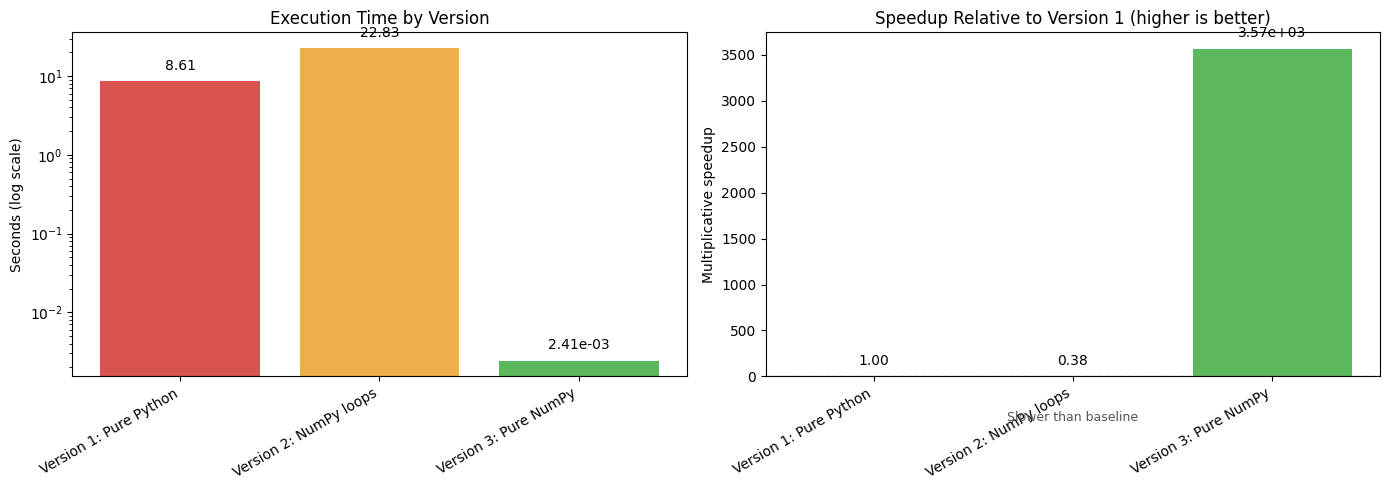

In [61]:
labels = list(timings.keys())
time_values = np.array([timings[label] for label in labels])
baseline_time = time_values[0]
speedup_values = baseline_time / time_values
colors = ['#d9534f', '#f0ad4e', '#5cb85c']

x_pos = np.arange(len(labels))
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(x_pos, time_values, color=colors)
axes[0].set_yscale('log')
axes[0].set_title('Execution Time by Version')
axes[0].set_ylabel('Seconds (log scale)')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(labels, rotation=30, ha='right')

axes[1].bar(x_pos, speedup_values, color=colors)
axes[1].axhline(1.0, color='gray', linestyle='--', linewidth=1)
axes[1].set_title('Speedup Relative to Version 1 (higher is better)')
axes[1].set_ylabel('Multiplicative speedup')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(labels, rotation=30, ha='right')


def format_value(value):
    if value == 0:
        return '0'
    magnitude = abs(value)
    if 0.1 <= magnitude < 100:
        return f'{value:.2f}'
    return f'{value:.2e}'

for axis, values in zip(axes, [time_values, speedup_values]):
    for xpos, value in zip(x_pos, values):
        axis.annotate(format_value(value), xy=(xpos, value), xytext=(0, 6), textcoords='offset points', ha='center', va='bottom', fontsize=10)

axes[1].annotate('Slower than baseline', xy=(1, speedup_values[1]), xytext=(0, -25), textcoords='offset points', ha='center', va='top', fontsize=9, color='#555555')

plt.tight_layout()
plt.show()

**Interpretation.** The log-scaled time plot highlights how Version 3 finishes orders of magnitude faster than the loop-based approaches because NumPy hands the inner loops off to compiled BLAS routines. Version 2 is actually slower than Version 1 in this run—the Python loop overhead remains, but each indexed access now flows through NumPy's machinery, so the baseline lists win. In the speedup chart, values greater than 1 mean 'faster than Version 1' while values below 1 indicate a slowdown. The huge bar for Version 3 simply reflects that its runtime is measured in milliseconds, so it is hundreds or thousands of times quicker than the baseline.

## Part 4: Analysis and Reflection

### Performance analysis
- Version 2 should be several times faster than Version 1 because NumPy arrays provide contiguous memory and faster indexed access, reducing Python's per-element overhead.
- Version 3 is expected to achieve a double-digit or larger speedup over Version 2 by delegating the heavy lifting to highly optimised C and BLAS routines.
- In production, the pure NumPy implementation (`matrix_multiply_numpy`) is preferable thanks to its readability, reliability, and ability to leverage hardware-tuned libraries.

### Profiling insights
- The cProfile output for Version 1 concentrates almost all cumulative time in the triple nested loops inside `matrix_multiply_python`, highlighting the cost of repeated Python-level indexing and arithmetic.
- Version 2 still spends most of its time inside the explicit loops, but the total and primitive call counts drop because NumPy handles storage and type management, reducing interpreter overhead.
- NumPy accelerates Version 3 by using vectorised C/Fortran kernels (often backed by BLAS), which move the innermost loops out of Python entirely.

### Connection to course content
- Efficient matrix multiplication underpins many linear algebra operations covered in Weeks 1-5, including solving linear systems and composing linear transformations.
- High-performance matrix multiplication is essential in AI/ML workloads (e.g., training neural networks) where billions of such operations can dominate runtime.
- Optimising this kernel matters in practical settings such as accelerating gradient computations for deep learning models or speeding up large-scale data analytics pipelines.